In [1]:
### 0. Load necessary packages

# General, data handling and visualization
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data preprocessing, ML model training & validation
from sklearn.utils import resample
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import autosklearn.classification
import sklearn.metrics
from sklearn.externals import joblib # to save models

# Pipelining & PMML export
from sklearn.pipeline import Pipeline
#from sklearn2pmml.pipeline import PMMLPipeline
#from sklearn2pmml import sklearn2pmml

print('Packages successfully loaded.')

Packages successfully loaded.


In [2]:
### Read in a sample dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
col_names = data.feature_names

print(X.shape)
print(y.shape)

#print(X[:4,:])
print(col_names)

## Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

(569, 30)
(569,)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [3]:
def predict(model, X):
    predictions = model.predict_proba(X)[:,1]

    return predictions.tolist()

def validate(model, X, y):
    # predict
    predictions_prob = predict(model,X)
    predictions_rounded = np.round(predictions_prob)

    # find roc curve
    fpr,tpr,_ = sklearn.metrics.roc_curve(y, predictions_prob)
    roc_curve = {'false_positive_rate':fpr.tolist(),'true_positive_rate':tpr.tolist()}

    # find auc
    auc = sklearn.metrics.auc(fpr,tpr)

    # find accuracy
    acc = sklearn.metrics.accuracy_score(y, predictions_rounded,normalize=True)

    # find log_loss
    log_loss = sklearn.metrics.log_loss(y, predictions_prob)

    # find precision
    precision = sklearn.metrics.precision_score(y,predictions_rounded)

    # find recall
    recall = sklearn.metrics.recall_score(y,predictions_rounded)
    
    # find specificity
    specificity = sklearn.metrics.recall_score(1-y,1-predictions_rounded)

    # find f1-score
    f1score = sklearn.metrics.f1_score(y,predictions_rounded)

    # find precision-recall curve
    prec, rec, _ = precision_recall_curve = sklearn.metrics.precision_recall_curve(y,predictions_prob)
    precision_recall_curve = {'recall':rec.tolist(),'precision':prec.tolist()}

    # find confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y, predictions_rounded).tolist()

    print('area_under_curve: '+'{:.3f}'.format(auc))
    print('accuracy: '+'{:.3f}'.format(acc))
    print('log_loss: '+'{:.3f}'.format(log_loss))
    print('precision: '+'{:.3f}'.format(precision))
    print('recall: '+'{:.3f}'.format(recall))
    print('specificity: '+'{:.3f}'.format(specificity))
    print('f1_score: '+'{:.3f}'.format(f1score))
    print()
        
    print('confusion_matrix:')
    print(confusion_matrix)
    print()
    
    print('roc_curve:')
    plot_ROC_curve(roc_curve, auc)
    print()
    
    print('precision_recall_curve:')
    plot_precision_recall_curve(precision_recall_curve)


def plot_ROC_curve(roc_curve, auc):
    plt.figure()
    lw = 2
    plt.plot(roc_curve['false_positive_rate'], roc_curve['true_positive_rate'], color='darkorange',
         lw=lw, label='ROC curve (AUC = '+'{:.3f}'.format(auc)+')')
    plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.clf()
    
def plot_precision_recall_curve(precision_recall_curve):
    plt.figure()
    lw = 2
    plt.plot(precision_recall_curve['recall'], precision_recall_curve['precision'], color='blue',
         lw=lw, label='precision-recall curve')
    plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()
    plt.clf()    

area_under_curve: 0.992
accuracy: 0.965
log_loss: 0.105
precision: 0.948
recall: 1.000
specificity: 0.902
f1_score: 0.974

confusion_matrix:
[[46, 5], [0, 92]]

roc_curve:


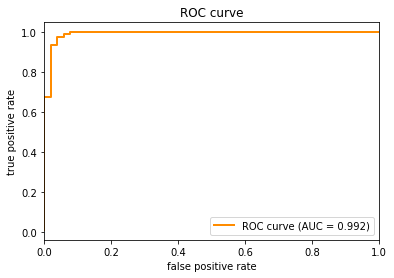


precision_recall_curve:


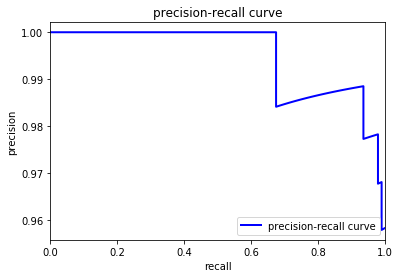

In [4]:
### LOGISTIC REGRESSION WITHOUT BALANCING

## Create logistic regression classifier object (other pipeline elements are defined already above)
scale = StandardScaler(with_mean=False)
LR_clf = LogisticRegression()

## Create pipeline
logistic_regression_pipeline = Pipeline([('scaling', scale),
                                         ('classifier', LR_clf)])

## Fit the pipeline - it's necessary to specify the option 'records' in the to_dict() function
logistic_regression_pipeline.fit(X_train, y_train)

## Test the pipeline by making predictions and computing metrics
validate(logistic_regression_pipeline, X_test, y_test)

In [8]:
#print(logistic_regression_pipeline.predict(X_test[0]))
print()
print(list(logistic_regression_pipeline.predict(X_test[:2,:])))


[1, 0]


In [9]:
features_df = pd.DataFrame(X_test, columns = col_names)
features_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,11.66,17.07,73.70,421.0,0.07561,0.03630,0.008306,0.01162,0.1671,0.05731,...,13.28,19.74,83.61,542.5,0.09958,0.06476,0.03046,0.04262,0.2731,0.06825
1,20.20,26.83,133.70,1234.0,0.09905,0.16690,0.164100,0.12650,0.1875,0.06020,...,24.19,33.81,160.00,1671.0,0.12780,0.34160,0.37030,0.21520,0.3271,0.07632
2,16.46,20.11,109.30,832.9,0.09831,0.15560,0.179300,0.08866,0.1794,0.06323,...,17.79,28.45,123.50,981.2,0.14150,0.46670,0.58620,0.20350,0.3054,0.09519
3,14.97,16.95,96.22,685.9,0.09855,0.07885,0.026020,0.03781,0.1780,0.05650,...,16.11,23.00,104.60,793.7,0.12160,0.16370,0.06648,0.08485,0.2404,0.06428
4,16.26,21.88,107.50,826.8,0.11650,0.12830,0.179900,0.07981,0.1869,0.06532,...,17.73,25.21,113.70,975.2,0.14260,0.21160,0.33440,0.10470,0.2736,0.07953


In [22]:
from flask import Flask, jsonify
import json

# this won't work without app context
#jsonify(features_df.head())

features_dict = features_df.head().to_dict()

print(features_dict)
print()

json_string = json.dumps(features_dict)
print(json_string)
print()

loaded_dict = json.loads(json_string)
print(loaded_dict)
print()

query_df = pd.DataFrame(loaded_dict, columns=loaded_dict.keys())

query_df

{'mean radius': {0: 11.66, 1: 20.2, 2: 16.46, 3: 14.97, 4: 16.26}, 'mean texture': {0: 17.07, 1: 26.83, 2: 20.11, 3: 16.95, 4: 21.88}, 'mean perimeter': {0: 73.7, 1: 133.7, 2: 109.3, 3: 96.22, 4: 107.5}, 'mean area': {0: 421.0, 1: 1234.0, 2: 832.9, 3: 685.9, 4: 826.8}, 'mean smoothness': {0: 0.07561, 1: 0.09905, 2: 0.09831, 3: 0.09855, 4: 0.1165}, 'mean compactness': {0: 0.0363, 1: 0.1669, 2: 0.1556, 3: 0.07885, 4: 0.1283}, 'mean concavity': {0: 0.008306, 1: 0.1641, 2: 0.1793, 3: 0.02602, 4: 0.1799}, 'mean concave points': {0: 0.01162, 1: 0.1265, 2: 0.08866, 3: 0.03781, 4: 0.07981}, 'mean symmetry': {0: 0.1671, 1: 0.1875, 2: 0.1794, 3: 0.178, 4: 0.1869}, 'mean fractal dimension': {0: 0.05731, 1: 0.0602, 2: 0.06323, 3: 0.0565, 4: 0.06532}, 'radius error': {0: 0.3534, 1: 0.9761, 2: 0.3037, 3: 0.2713, 4: 0.5706}, 'texture error': {0: 0.6724, 1: 1.892, 2: 1.284, 3: 1.217, 4: 1.457}, 'perimeter error': {0: 2.225, 1: 7.128, 2: 2.482, 3: 1.893, 4: 2.961}, 'area error': {0: 26.03, 1: 103.6, 2:

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,11.66,17.07,73.70,421.0,0.07561,0.03630,0.008306,0.01162,0.1671,0.05731,...,13.28,19.74,83.61,542.5,0.09958,0.06476,0.03046,0.04262,0.2731,0.06825
1,20.20,26.83,133.70,1234.0,0.09905,0.16690,0.164100,0.12650,0.1875,0.06020,...,24.19,33.81,160.00,1671.0,0.12780,0.34160,0.37030,0.21520,0.3271,0.07632
2,16.46,20.11,109.30,832.9,0.09831,0.15560,0.179300,0.08866,0.1794,0.06323,...,17.79,28.45,123.50,981.2,0.14150,0.46670,0.58620,0.20350,0.3054,0.09519
3,14.97,16.95,96.22,685.9,0.09855,0.07885,0.026020,0.03781,0.1780,0.05650,...,16.11,23.00,104.60,793.7,0.12160,0.16370,0.06648,0.08485,0.2404,0.06428
4,16.26,21.88,107.50,826.8,0.11650,0.12830,0.179900,0.07981,0.1869,0.06532,...,17.73,25.21,113.70,975.2,0.14260,0.21160,0.33440,0.10470,0.2736,0.07953


In [20]:
print(logistic_regression_pipeline.predict(features_df.head()))
print()
print(logistic_regression_pipeline.predict(query_df))

[1 0 0 1 0]

[1 0 0 1 0]


In [29]:
col_names = ['var_1', 'var_2', 'var_3']
input_variables =  [[1], [2], [3]]
zipped = list(zip(col_names, input_variables))
zipped

[('var_1', [1]), ('var_2', [2]), ('var_3', [3])]

In [30]:
data = dict(zipped)
data

{'var_1': [1], 'var_2': [2], 'var_3': [3]}

In [32]:
df_1 = pd.DataFrame(data)
df_1

,var_1,var_2,var_3
0,1,2,3


In [33]:
json_string = json.dumps(data)
json_string


'{"var_1": [1], "var_2": [2], "var_3": [3]}'